In [1]:
# Environment Setup
# ----------------------------------------------------------------
# Dependencies
import csv
import pandas as pd
import random
import numpy as np
import string
import matplotlib.pyplot as plt
from faker import Faker
fake = Faker()

# Output File Names
file_output_city_csv = "generated_data/city_data.csv"
file_output_rides_csv = "generated_data/ride_data.csv"

# Generator Conditions (Change as needed)
# ----------------------------------------------------------------
rough_ride_count = 2500
rough_driver_count = 950
city_count = 120
city_types = [
    {
        "type": "Urban",
        "fare_range": (4, 45),
        "percent_of_rides": 0.65,
        "percent_of_drivers": 0.65,
        "percentage_of_cities": 0.55
    },
    {
        "type": "Suburban",
        "fare_range": (12, 50),
        "percent_of_rides": 0.25,
        "percent_of_drivers": 0.25,
        "percentage_of_cities": 0.35
    },
    {
        "type": "Rural",
        "fare_range": (10, 60),
        "percent_of_rides": 0.05,
        "percent_of_drivers": 0.10,
        "percentage_of_cities": 0.15
    }
]

In [2]:
# Create a CSV of city data 
# City | Driver_Count | Type

# List will hold the final set of city data 
cities_data = []

# Calculate the driver count for each city type
for city_type in city_types:
    city_type["total_drivers"] = int(city_type["percent_of_drivers"] * rough_driver_count)
    city_type["city_count"] = int(city_type["percentage_of_cities"] * city_count)
    
    # Use the driver count to create a set number of fake cities each given a random number of drivers
    for city in range(city_type["city_count"]):
        cities_data.append({"city": fake.city(), 
                       "type": city_type["type"], 
                       "driver_count": np.random.randint(1, city_type["total_drivers"] * 0.12)})

# Convert the city data into a DataFrame    
cities_pd = pd.DataFrame(cities_data)

# Export the city data to a csv 
cities_pd.to_csv(file_output_city_csv, index=False)

cities_pd.set_index(keys="city")
cities_pd.head()

,city,driver_count,type
0,Wadehaven,35,Urban
1,Port Tonyfurt,11,Urban
2,Lopezborough,21,Urban
3,East Barbara,10,Urban
4,Tiffanyport,31,Urban


In [3]:
# Create a CSV of ride data
# Ride ID | City | Date | Fare | 

# List will hold all the final set of rides
rides = []

# Loop through all city types
for city_type in city_types:
    
    # Determine the total rides for each city type
    city_type["total_rides"] = int(city_type["percent_of_rides"] * rough_ride_count)
    
    # Choose a city from that city type at random to distribute the rides across cities
    for ride in range(city_type["total_rides"]):
        
        # Create a list of dictionaries for each ride
        rides.append({"ride_id": fake.ean13(), 
                      "date": fake.date_time_this_year(), 
                      "city": np.random.choice(cities_pd[cities_pd["type"] == city_type["type"]]["city"]), 
                      "fare": round(np.random.uniform(city_type["fare_range"][0], city_type["fare_range"][1]), 2)})

# Convert the ride list into a data frame
rides_pd = pd.DataFrame(rides)

# Export the ride data to a csv
rides_pd.to_csv(file_output_rides_csv, index=False)

rides_pd.set_index(keys="city")
rides_pd.head()

,city,date,fare,ride_id
0,Nicoleville,2018-02-08 09:23:47,24.30,8785341428097
1,Stacychester,2018-03-04 23:52:33,38.73,3278871786355
2,South Steven,2018-01-21 05:51:14,8.43,5470075233262
3,Clementsmouth,2018-02-06 18:10:52,8.30,3159038750061
4,Smithshire,2018-02-08 08:27:33,11.36,4726763293249


In [4]:
# Build a Bubble Plot to show the following relationships
#   Average Fare ($) Per City
#   Total Number of Rides Per City
#   Total Number of Drivers Per City
#   City Type (Urban, Suburban, Rural)

# Calculate the average fare by city with results saved in a data frame
ave_fare = pd.DataFrame(rides_pd)
ave_fare = ave_fare.groupby('city', as_index=False).agg({'fare':'mean'})

# Calculate the total number of rides per city
total_rides = rides_pd
total_rides = total_rides.groupby('city', as_index=False).agg({'fare':'count'})
total_rides.rename(columns ={'fare' : 'total_rides'}, inplace=True)

results = pd.concat([ave_fare, total_rides], axis=1)

# Remove duplicate 'city' column
results = results.loc[:,~results.columns.duplicated()]

results = pd.merge(results, cities_pd, how='left', on='city')

# Create array by city type.
urban_data = results.loc[results['type'] == 'Urban']
suburban_data = results.loc[results['type'] == 'Suburban']
rural_data = results.loc[results['type'] == 'Rural']

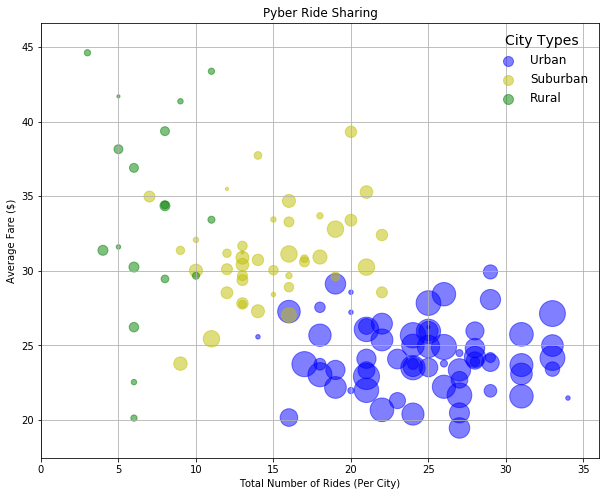

In [5]:
# Build the Bubble Plot

plt.figure(figsize=(10,8))

urban_driver_list = urban_data["driver_count"]
suburban_driver_list = suburban_data["driver_count"]
rural_driver_list = rural_data["driver_count"]

# PLOT TOTAL RIDES by AVERAGE FARE
plt.scatter(x=urban_data["total_rides"], y=urban_data["fare"], s=[i*10 for i in urban_driver_list], alpha=0.5, c='b', label='Urban')
plt.scatter(x=suburban_data["total_rides"], y=suburban_data["fare"], s=[i*10 for i in suburban_driver_list], alpha=0.5, c='y', label='Suburban')
plt.scatter(x=rural_data["total_rides"], y=rural_data["fare"], s=[i*10 for i in rural_driver_list], alpha=0.5, c='g', label='Rural')

# ADJUST FIGURE SIZE TO FIT ALL EXTREME POINTS
plt.xlim(0, max(max(urban_data["total_rides"]),max(suburban_data["total_rides"]),max(rural_data["total_rides"])) + 2)
plt.ylim(min(min(urban_data["fare"]),min(suburban_data["fare"]),min(rural_data["fare"])) - 2,
         max(max(urban_data["fare"]),max(suburban_data["fare"]),max(rural_data["fare"])) + 2)

# CREATE LEGEND
# Make the legend title slightly larger than the legend
lgnd = plt.legend(fontsize=12, markerscale=1, frameon=False, title='City Types', loc="best")
plt.setp(lgnd.get_title(),fontsize=14)
# Set legend handle to be the same size
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]

# SHOW BUBBLE PLOT TITLE, and X and Y axis labels.
plt.title('Pyber Ride Sharing')
plt.xlabel("Total Number of Rides (Per City)")
plt.ylabel("Average Fare ($)")

plt.grid()
plt.show()

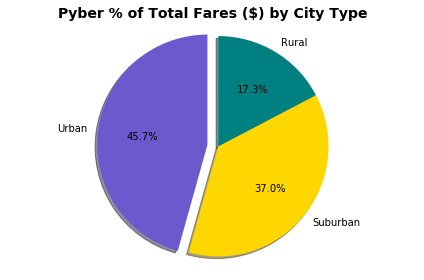

In [6]:
# Pie Chart # 1 - % of Total Fares by City Type

# Calculate % of total fares for each city type
urban_fare_percent = (urban_data['fare'].sum()/results['fare'].sum()) * 100
suburban_fare_percent = (suburban_data['fare'].sum()/results['fare'].sum()) * 100
rural_fare_percent = (rural_data['fare'].sum()/results['fare'].sum()) * 100

# Data to plot pie chart by % of Total Fares by City Type
labels = ['Urban', 'Suburban', 'Rural']
city_type_percent = [urban_fare_percent, suburban_fare_percent, rural_fare_percent]
colors = ['slateblue', 'gold', 'teal']
explode = [0.1, 0, 0]

plt.pie(city_type_percent, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)

plt.title('Pyber % of Total Fares ($) by City Type', fontsize=14, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

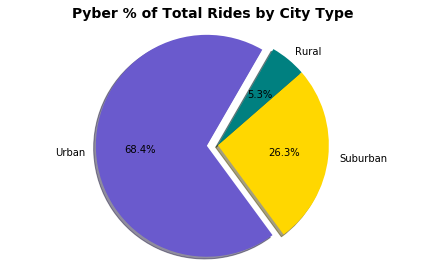

In [7]:
# Pie Chart # 2 - % of Total Rides by City Type

# Calculate % of total rides for each city type
urban_ride_percent = (urban_data['total_rides'].sum()/results['total_rides'].sum()) * 100
suburban_ride_percent = (suburban_data['total_rides'].sum()/results['total_rides'].sum()) * 100
rural_ride_percent = (rural_data['total_rides'].sum()/results['total_rides'].sum()) * 100

# Data to plot pie chart by % of Total Rides by City Type
labels = ['Urban', 'Suburban', 'Rural']
city_type_percent = [urban_ride_percent, suburban_ride_percent, rural_ride_percent]
colors = ['slateblue', 'gold', 'teal']
explode = [0.1, 0, 0]

plt.pie(city_type_percent, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle= 60)

plt.title('Pyber % of Total Rides by City Type', fontsize=14, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

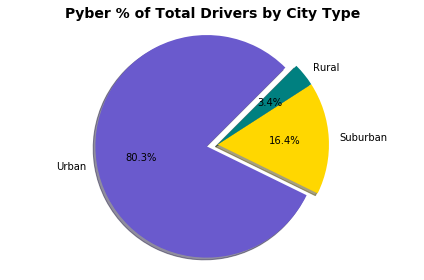

In [8]:
# Pie Chart # 3 - % of Total Drivers by City Type

# Calculate % of total drivers for each city type
urban_driver_percent = (urban_data['driver_count'].sum()/results['driver_count'].sum()) * 100
suburban_driver_percent = (suburban_data['driver_count'].sum()/results['driver_count'].sum()) * 100
rural_driver_percent = (rural_data['driver_count'].sum()/results['driver_count'].sum()) * 100

# Data to plot pie chart by % of Total Drivers by City Type
labels = ['Urban', 'Suburban', 'Rural']
city_type_percent = [urban_driver_percent, suburban_driver_percent, rural_driver_percent]
colors = ['slateblue', 'gold', 'teal']
explode = [0.1, 0, 0]

plt.pie(city_type_percent, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle= 45)

plt.title('Pyber % of Total Drivers by City Type', fontsize=14, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()